In [196]:
import json
import time
from stop_words import get_stop_words
from gensim.models.doc2vec import TaggedDocument,Doc2Vec
from textblob import TextBlob
import pandas as pd
import numpy as np
from scipy import spatial,stats
import matplotlib.pyplot as plt
from sklearn.manifold import TSNE
import csv

<h2>Text Data</h2>

Reads in the ISEAR emotion dataset into Pandas dataframe. http://emotion-research.net/toolbox/toolboxdatabase.2006-10-13.2581092615

In [92]:
df_isear = pd.read_csv('ISEAR1.csv',index_col=False)

In [93]:
df_isear.head()

,emotion,text
0,joy,On days when I feel close to my partner and ot...
1,fear,Every time I imagine that someone I love or I ...
2,anger,When I had been obviously unjustly treated and...
3,sadness,When I think about the short time that we live...
4,disgust,At a gathering I found myself involuntarily si...


<h2>Model Creation Functions</h2>

Function will prepare a list of articles and create a do2vec model from them. 

In [94]:
def create_doc2vec_model(articles,name,vector_size=100,epochs=10,lang='en'):
    # import stopwords for specific language of model
    stop_words = get_stop_words(lang)
    ## list of just articles (str)
    #strip stopwords article docs
    nostop = [[i for i in doc.lower().split() if i not in stop_words] for doc in articles]
    #tokenize article docs and convert to doc2vec tagged docs - each article has an index number and list of tokens - taggedoc(['token1','token2',[1]])
    tagged = [TaggedDocument(doc,[i]) for i,doc in enumerate(nostop)]
    # instantiate doc2vec model with parameters - size = # of nums representing each doc (100), min_count - occurences of words in vocab (filter out rare words), iter - passes to create vectors
    model = Doc2Vec(vector_size=vector_size, min_count=2, epochs=epochs)
    ## build vocab from all tagged docs
    model.build_vocab(tagged)
    ## train model on tagged docs - total examples - total # of docs
    model.train(tagged,total_examples=model.corpus_count,epochs=epochs)
    # save model with language - eg esmodel.model for spanish docs
    model_name = name + 'model.model'
    model.save(model_name)
    model.delete_temporary_training_data(keep_doctags_vectors=True, keep_inference=True)
    print('saved as: ' + model_name)

<h2>Group Data by Emotion</h2>

Create ids for each emotion and group sentences by emotion.

Each emotion group contains roughly the same number of sentences  - ranging from 1050 - 1092. 

In [95]:
emotion_id = []
for x in df_isear['emotion']:
    if x == 'anger':
        emotion_id.append(0)
    if x == 'disgust':
        emotion_id.append(1)
    if x == 'fear':
        emotion_id.append(2)
    if x == 'guilt':
        emotion_id.append(3)
    if x == 'joy':
        emotion_id.append(4)
    if x == 'sadness':
        emotion_id.append(5)
    if x == 'shame':
        emotion_id.append(6)

In [96]:
df_isear['id'] = emotion_id

In [119]:
df_isear.head()

,emotion,text,id
0,joy,On days when I feel close to my partner and ot...,4
1,fear,Every time I imagine that someone I love or I ...,2
2,anger,When I had been obviously unjustly treated and...,0
3,sadness,When I think about the short time that we live...,5
4,disgust,At a gathering I found myself involuntarily si...,1


In [124]:
dfgrp = df_isear.groupby('emotion')

In [125]:
dfgrp.count()

,text,id
emotion,,
anger,1079,1079
disgust,1066,1066
fear,1076,1076
guilt,1050,1050
joy,1092,1092
sadness,1082,1082
shame,1071,1071


<h2>Create Single Document for Each Emotion</h2>

Collect all the sentences for a given emotion in one document. 

In [129]:
emotions = list(df_isear.groupby(df_isear['emotion']))

In [130]:
anger = ' '.join(emotions[0][1]['text'])
disgust = ' '.join(emotions[1][1]['text'])
fear = ' '.join(emotions[2][1]['text'])
guilt = ' '.join(emotions[3][1]['text'])
joy = ' '.join(emotions[4][1]['text'])
sadness= ' '.join(emotions[5][1]['text'])
shame = ' '.join(emotions[6][1]['text'])

In [144]:
emotion_docs = [anger,disgust,fear,guilt,joy,sadness,shame]
emotions = ['anger','disgust','fear','guilt','joy','sadness','shame']

<h2>Create Doc2Vec Model From Emotion Documents</h2>

A vector space will be created from the emotion documents and each emotion document will have a vector representation within that space. 

Load the newly creatd Doc2Vec model and store the vector representations of each emotion document in a list.

In [132]:
create_doc2vec_model(emotion_docs ,'emotions',vector_size=100,epochs=10,lang='en')

saved as: emotionsmodel.model


In [133]:
d2v_model = Doc2Vec.load('emotionsmodel.model')

In [147]:
emot_vecs = [d2v_model.docvecs[i] for i,x in enumerate(emotions)]

In [173]:
emot_vectors = list(zip(emotions,emot_vecs))

<h2>Infer Vectors From List of Text Items</h2>

Function will preprocess a list of text items and infer vectors for them from the newly created Doc2Vec model. 

In [174]:
def text2vec(textlist,lang,d2v_model):
    stop_words = get_stop_words(lang)
    histnostop = [[i for i in doc.lower().split() if i not in stop_words] for doc in textlist]
    dlhist_tagged = [TaggedDocument(doc,[i]) for i,doc in enumerate(histnostop)]
    ## infer vectors from current doc2model
    vecs = [d2v_model.infer_vector(doc.words) for doc in dlhist_tagged]
    return vecs

In [175]:
sample_sent = ['You mean so much to me and I love you.','How could you do that you bastard. I cannot stand you!'] #sentences must be in a list

In [203]:
sample_vec = text2vec(sample_sent,'en',d2v_model)

In [204]:
sample_vec[0]

array([ 0.04967122, -0.01885439, -0.02742223,  0.00629402, -0.01563814,
       -0.03423334,  0.00706906, -0.01418472, -0.01894525,  0.02464414,
        0.03675739,  0.00742269, -0.00102734, -0.0390313 ,  0.00393074,
       -0.0092905 ,  0.00380828, -0.03491097,  0.03660998,  0.01793002,
       -0.00326422,  0.01564755, -0.02886198, -0.00446593, -0.01151069,
        0.02740809, -0.00741997,  0.02514804,  0.02922452,  0.00331974,
        0.00134247,  0.00040877,  0.01959951,  0.00903411, -0.00278456,
        0.02115019,  0.0015956 ,  0.00717093, -0.01282372, -0.02305254,
       -0.01705219, -0.00353309, -0.00688013,  0.00857654,  0.0030448 ,
       -0.01894695,  0.02710157,  0.02208279,  0.02091953, -0.02427766,
        0.01239031,  0.02803985,  0.00547659,  0.03087698,  0.02589514,
        0.00436824,  0.02033944, -0.01289238,  0.01733798,  0.00065215,
       -0.00426254,  0.0219882 ,  0.0342768 ,  0.03196919,  0.02000389,
        0.0129513 , -0.01391707, -0.00231978, -0.00308594,  0.00

In [205]:
isear_infer_vecs = text2vec(df_isear['text'],'en',d2v_model)

<h2>Create .tsv files</h2>

Functions for creating tsv files for use in a Tensorflow Embedding Projector

In [192]:
## outputs and saves a tsv file for a list of vectors
def output_tab_vecs(vecs,filename):
    csv.register_dialect('tabDialect', delimiter='\t', quoting=csv.QUOTE_NONE)
    myFile = open(filename, 'w')  
    with myFile:  
        writer = csv.writer(myFile, dialect='tabDialect')
        writer.writerows(vecs)
    print('saved tab file as',filename)

In [193]:
## outputs and saves a tsv file for a list of meta tags (2 columns or more)
def output_tab_meta(meta,filename):
    csv.register_dialect('tabDialect', delimiter='\t', quoting=csv.QUOTE_NONE,escapechar='\\')
    myFile = open(filename, 'w')  
    with myFile:  
        writer = csv.writer(myFile, dialect='tabDialect')
        writer.writerows(meta)
    print('saved tab file as',filename)

In [194]:
## outputs and saves a tsv file for a list of single column meta tags
def output_single_meta(metalist,filename):
    with open (filename, 'w') as fo:
        for d in metalist:
            fo.write(str(d) + '\n')
    print('saved tab file as',filename)

Output tsv files for the vector means for each emotion and theirs labels as well as the vectors for each sentence and their labels (emotion,sentence text). 

In [207]:
output_tab_vecs(emot_vecs,'emot_vecs_docs.tsv')

saved tab file as emot_vecs_docs.tsv


In [208]:
output_single_meta(emotions,'emot_labels_docs.tsv')

saved tab file as emot_labels_docs.tsv


In [209]:
output_tab_vecs(isear_infer_vecs,'emot_vecs_docs_isear_sents.tsv')

saved tab file as emot_vecs_docs_isear_sents.tsv


In [210]:
meta_list = list(zip(df_isear['emotion'],df_isear['text']))
output_tab_meta(meta_list,'emot_labels_doc_isear_sents.tsv')

saved tab file as emot_labels_doc_isear_sents.tsv


<h2>Tensorflow Embedding Projector </h2>

Links use data previously generated in this notebook that is hosted on github. To use yoru own data, one can generate the required tsv files with the functions above and then upload the vec and meta .tsv files to the embedding projector with the 'Load Data' button and choose the appropriate file (vectors or metadata). 

https://projector.tensorflow.org/?config=https://gist.githubusercontent.com/escottgoodwin/c4420996ba29cab5ec300727bb94f936/raw/07592b11817d2496281e2e25b268b3ffa0fe1b89/emotion_doc_config.json

<h2>Predict Emotions</h2>

Function will use cosine similarity to provide a 'score' for each of the emotion categories (anger:.84,joy:.21, sadness: .54....) as well as predict the most dominant emotion to compare against the oringal data's labels. 

Function will also return the vectors for each text item. 


In [178]:
def predict_emotions(text_list,lang,emotion_vecs,model_name):
    d2v_model = Doc2Vec.load(model_name)
    text_vecs = text2vec(text_list,lang,d2v_model)
    emot_scan = [{x[0]: 1 - spatial.distance.cosine(sample_vec,x[1]) for x in emot_vectors} for sample_vec in text_vecs]
    emot_pred = [np.argmax(x) for x in emot_scan]
    return emot_scan,emot_pred,text_vecs
    

In [185]:
emot_scan,emot_pred,text_vecs = predict_emotions(sample_sent,'en',emot_vecs,'emotionsmodel.model')

In [186]:
emot_scan

[{'anger': 0.6887170672416687,
  'disgust': 0.7992683053016663,
  'fear': 0.8286601305007935,
  'guilt': 0.5883464813232422,
  'joy': 0.9636943936347961,
  'sadness': 0.8205100893974304,
  'shame': 0.7367916703224182},
 {'anger': 0.7632464170455933,
  'disgust': 0.6065824627876282,
  'fear': 0.3797411322593689,
  'guilt': 0.8659026026725769,
  'joy': 0.2196638137102127,
  'sadness': 0.5754576325416565,
  'shame': 0.7853734493255615}]

<h2>Predict Emotions for All Sentences in ISEAR Dataset</h2>

Use the prediction function to generate predictions for every sentences in the Isear Dataset. One can compare emot_pred (highest scored emotion) with the emotion label in the original dataset.  

In [187]:
isear_sents = list(df_isear['text'])

In [190]:
emot_scan_all,emot_pred_all,text_vecs_all = predict_emotions(isear_sents,'en',emot_vecs,'emotionsmodel.model')

In [191]:
emot_scan_all[0]

{'anger': 0.9276597499847412,
 'disgust': 0.9914762377738953,
 'fear': 0.6125450730323792,
 'guilt': 0.8508618474006653,
 'joy': 0.8188710808753967,
 'sadness': 0.8264458775520325,
 'shame': 0.9463430643081665}

<h2>Create .tsv Files of Predictions from ISEAR Sentences</h2>

Create .tsv files of the vectors and metadata (emotion,text) for each sentence. 

In [200]:
output_tab_vecs(text_vecs_all,'emot_vecs_doc_sent.tsv')

saved tab file as emot_vecs_doc_sent.tsv


In [199]:
meta_list = list(zip(df_isear['emotion'],df_isear['text']))
output_tab_meta(meta_list,'emot_labels_doc_sent.tsv')

saved tab file as emot_labels_doc_sent.tsv


<h2>Tensorflow Embedding Projector</h2>

Links use data previously generated in this notebook that is hosted on github. To use yoru own data, one can generate the required tsv files with the functions above and then upload the vec and meta .tsv files to the embedding projector with the 'Load Data' button and choose the appropriate file (vectors or metadata). 

<h3>Emotion Documents</h3>

Select 'emotion' for 'color by' so points will be colored by the emotion label.



In [83]:
labels = df_isear['emotion']
isear_vecs = list(df_isear['text_vecs'])

In [85]:
def emotion_chart(vecs,labels,annotate=False):
    tsne_model = TSNE(perplexity=40, n_components=2, init='pca', n_iter=2500, random_state=23)
    new_values = tsne_model.fit_transform(vecs)
    x = [x[0] for x in new_values]
    y = [x[1] for x in new_values]
    plt.figure(figsize=(16, 16)) 
    plot = [plt.scatter(x[i],y[i]) for i in range(len(x))]
    if annotate:
        plt.annotate(labels[i],
                     xy=(x[i], y[i]),
                     xytext=(5, 2),
                     textcoords='offset points',
                     ha='right',
                     va='bottom')
    plt.show()

In [88]:
tsne_model3D = TSNE(perplexity=40, n_components=3, init='pca', n_iter=2500, random_state=23)

In [89]:
new_values3D = tsne_model3D.fit_transform(isear_vecs)

In [92]:
x = [x[0] for x in new_values3D]
y = [x[1] for x in new_values3D]
z = [x[2] for x in new_values3D]

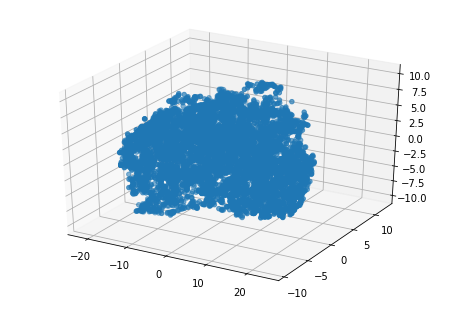

In [124]:
fig1 = plt.figure()
ax1 = Axes3D(fig1)
ax1.scatter(x,y,z)
plt.show()

In [122]:
for i in range(len(x)):
    ax1.scatter(x, y, z)
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()



In [103]:
vird = plt.get_cmap('viridis')
type(vird)

matplotlib.colors.ListedColormap

In [110]:
plt.show()

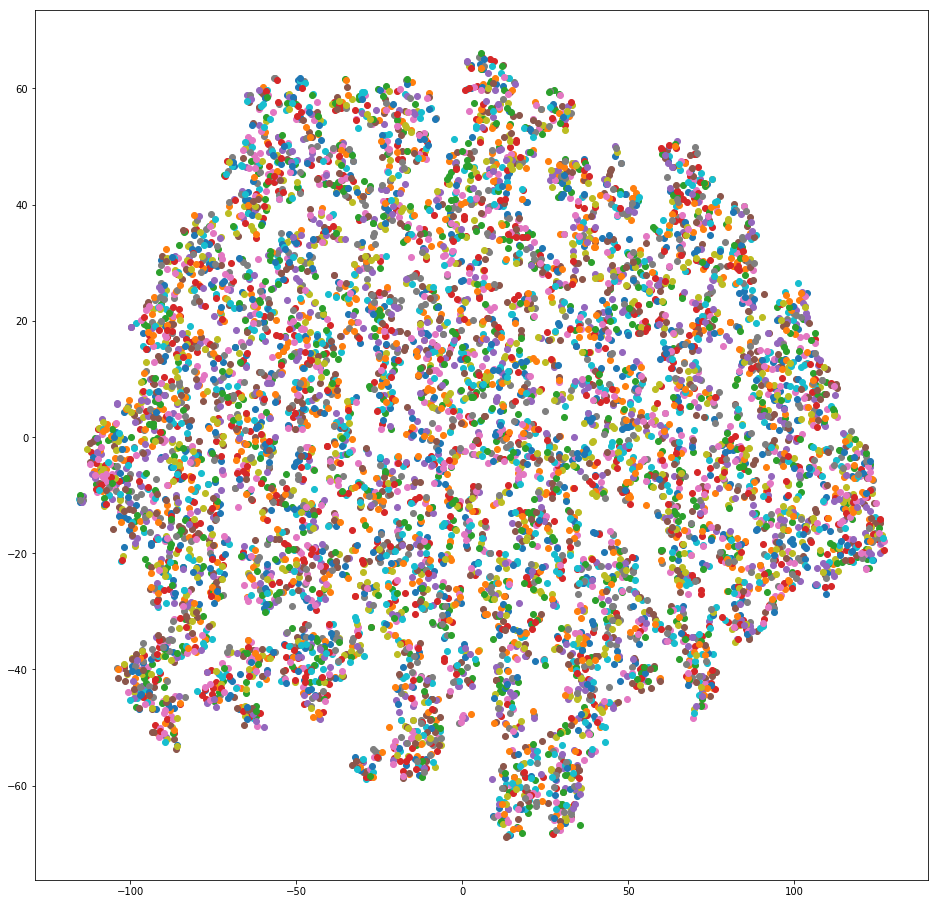

In [86]:
emotion_chart(isear_vecs,labels)

In [78]:
x = []
y = []
for value in new_values:
    x.append(value[0])
    y.append(value[1])


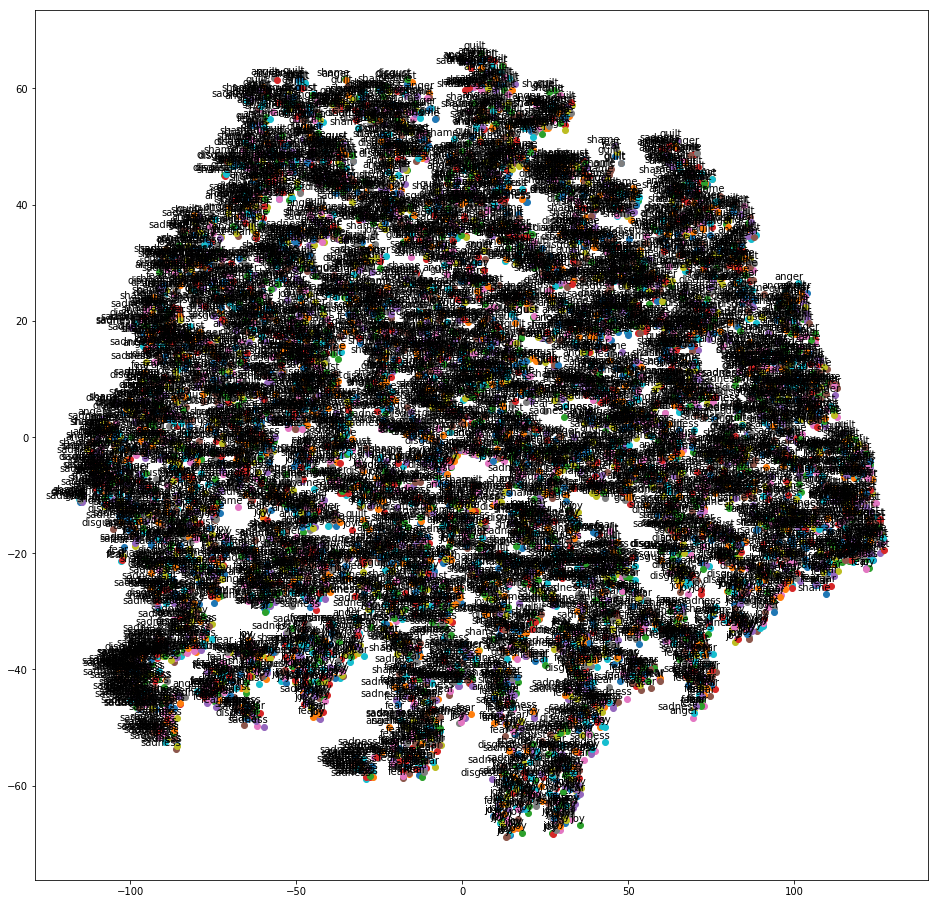

In [79]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
    plt.annotate(labels[i],
                 xy=(x[i], y[i]),
                 xytext=(5, 2),
                 textcoords='offset points',
                 ha='right',
                 va='bottom')
plt.show()



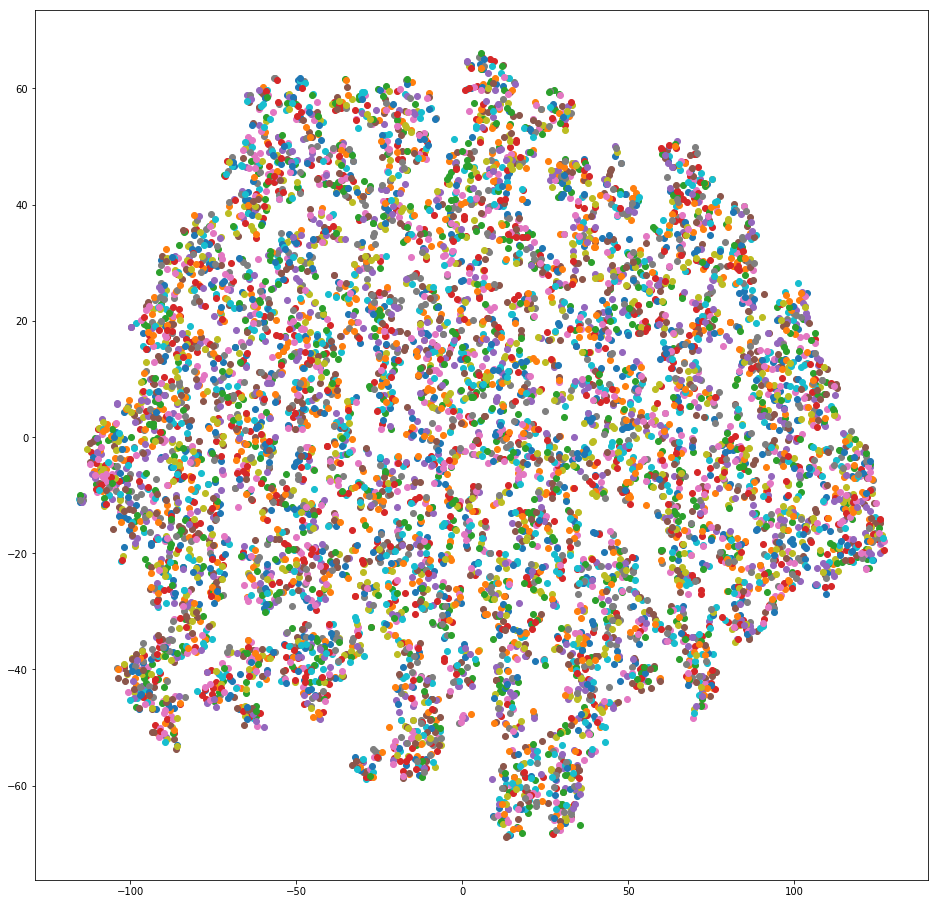

In [80]:
plt.figure(figsize=(16, 16)) 
for i in range(len(x)):
    plt.scatter(x[i],y[i])
plt.show()


In [62]:

plt.show()

In [181]:
list(int(x) for x in stats.rankdata(emot_eval['valence'].iloc[0]))

[5, 6, 1, 3, 2, 4, 7]

In [183]:
ranks = list(stats.rankdata(val) for val in emot_eval['valence'])

In [258]:
ranks

[array([5., 6., 1., 3., 2., 4., 7.]),
 array([2., 3., 6., 1., 4., 7., 5.]),
 array([4., 3., 2., 5., 1., 6., 7.]),
 array([7., 4., 1., 5., 2., 3., 6.]),
 array([3., 6., 1., 2., 4., 5., 7.]),
 array([6., 5., 1., 4., 2., 3., 7.]),
 array([6., 5., 1., 4., 2., 3., 7.]),
 array([7., 4., 1., 5., 2., 3., 6.]),
 array([4., 2., 5., 3., 1., 7., 6.]),
 array([3., 1., 7., 2., 5., 6., 4.]),
 array([5., 6., 1., 2., 3., 4., 7.]),
 array([7., 5., 1., 4., 2., 3., 6.]),
 array([3., 2., 6., 1., 5., 7., 4.]),
 array([6., 3., 2., 5., 1., 4., 7.]),
 array([3., 2., 5., 1., 7., 4., 6.]),
 array([5., 2., 3., 4., 1., 7., 6.]),
 array([6., 4., 1., 7., 2., 3., 5.]),
 array([4., 1., 3., 2., 6., 5., 7.]),
 array([5., 7., 1., 3., 2., 4., 6.]),
 array([4., 3., 2., 6., 1., 5., 7.]),
 array([6., 5., 1., 4., 3., 2., 7.]),
 array([3., 2., 4., 1., 6., 7., 5.]),
 array([2., 3., 7., 1., 5., 6., 4.]),
 array([6., 5., 1., 4., 2., 3., 7.]),
 array([4., 3., 2., 6., 1., 7., 5.]),
 array([3., 4., 2., 1., 5., 7., 6.]),
 array([7., 

In [199]:
corr = list(df_isear['id'])

In [201]:
corr_ranks = [ranks[x] for x in corr]
    

In [205]:
corr_ranks = list(zip(ranks,corr))

In [206]:
corr_ranks[0]

(array([5., 6., 1., 3., 2., 4., 7.]), 4)

In [208]:
corr_ranks[0][0][corr_ranks[0][1]]

2.0

In [209]:
corr_position = [x[0][x[1]] for x in corr_ranks]

In [225]:
post_arr = np.array(corr_position)
df_position = pd.DataFrame(post_arr)

In [245]:
position_grp = list(df_position.groupby([0]))


In [250]:
len(position_grp[0][1])

216

In [259]:
## ranking from lowest to highest so highest cosine score will have highest rank - [.4,.8,.9] = [1,2,3] ranks - highest rank is correct prediction

In [256]:
for x in position_grp:
    print(len(x[1])/len(corr_position))

0.028738690792974985
0.05228845130388504
0.11428951569984035
0.12187333688131985
0.1329164449175093
0.17708887706226717
0.3728046833422033


In [255]:
len(corr_position)

7516

In [257]:
df_position

,0
0,2.0
1,6.0
2,4.0
3,3.0
4,6.0
5,3.0
6,4.0
7,2.0
8,5.0
9,3.0
